<a href="https://colab.research.google.com/github/BrotherKim/KAIST_CODE/blob/master/SEP531/term/1_KoBERT_emotion_finetune_70000.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#실행 환경#

- Python >= 3.6
- PyTorch >= 1.70
- Transformers = 3.0.2
- Colab
- batch size = 64 (convertable)
- epochs = 10 (convertable)

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch

     |████████████████████████████████| 46.9 MB 51.0 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 5.3 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595729 sha256=3aeb0bc3486c0b893f6dacf7218544e55245751fd89b58b52babbcc8a1ffdba7
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 5.1 MB/s 
     |████████████████████████████████| 769 kB 5.2 MB/s 
     |████████████████████████████████| 3.0 MB 42.3 MB/s 
     |████████████████████████████████| 895 kB 37.1 MB/s 


#KoBERT 다운로드#

In [2]:
#깃허브에서 KoBERT 파일 로드
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

  Cloning https://****@github.com/SKTBrain/KoBERT.git (to revision master) to /tmp/pip-req-build-qpx2zs2f
  Running command git clone -q 'https://****@github.com/SKTBrain/KoBERT.git' /tmp/pip-req-build-qpx2zs2f
     |████████████████████████████████| 4.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.4 MB 45.7 MB/s 
     |████████████████████████████████| 3.3 MB 46.8 MB/s 
     |████████████████████████████████| 61 kB 549 kB/s 
     |████████████████████████████████| 596 kB 55.8 MB/s 
  Created wheel for kobert: filename=kobert-0.1.2-py3-none-any.whl size=13136 sha256=7f0aa22f382b4434169711257c71f818b860b1126c09df27efa21d55cf2914d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-b0bgvom9/wheels/d3/68/ca/334747dfb038313b49cf71f84832a33372f3470d9ddfd051c0
Successfully built kobert
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: tokenizers
    Found existi

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
#GPU 사용
device = torch.device("cuda:0")

In [6]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

.cache/kobert_v1.zip[██████████████████████████████████████████████████]
.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]


#데이터셋 전처리#

In [7]:
#구글드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import pandas as pd
chatbot_data = pd.read_excel('/content/drive/MyDrive/KAIST/SEP531/한국어_단발성_대화_데이터셋.xlsx')

In [9]:
chatbot_data.sample(n=10)

Sentence Emotion  ...   공포  5468
10170                             진짜 미쳤나봐      놀람  ...  NaN   NaN
6631   10일이 아니라 9일 날 여의도로 가야 하는 것 아닌가!!!!      놀람  ...  NaN   NaN
15010           유병재: 신인은 어디서 경력 쌓냐 이 꼰대들아      분노  ...  NaN   NaN
21222                          꿈인것같다...ㅠㅠ      슬픔  ...  NaN   NaN
17682                               힘이드네요      슬픔  ...  NaN   NaN
25000                          카피캣 입장이 됐네      중립  ...  NaN   NaN
4620            수능 폐지한다는 얘기나오던데 정말 폐지해..?      공포  ...  NaN   NaN
4393        이러다가 트럼프때문에 경상도사람들 천민 취급하겠는데.      공포  ...  NaN   NaN
11906                          아고 인제 숨쉬겠다      분노  ...  NaN   NaN
36777        요즘 제조사들 본인이 명품인줄 아는데 착각하지 마쇼      혐오  ...  NaN   NaN

[10 rows x 7 columns]

In [10]:
chatbot_data.loc[(chatbot_data['Emotion'] == "공포"), 'Emotion'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['Emotion'] == "놀람"), 'Emotion'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['Emotion'] == "분노"), 'Emotion'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['Emotion'] == "슬픔"), 'Emotion'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['Emotion'] == "중립"), 'Emotion'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['Emotion'] == "행복"), 'Emotion'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['Emotion'] == "혐오"), 'Emotion'] = 6  #혐오 => 6

data_list = []
for q, label in zip(chatbot_data['Sentence'], chatbot_data['Emotion'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [11]:
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])
print(data_list[24000])
print(data_list[30000])
print(data_list[-1])
print(len(data_list))

['언니 동생으로 부르는게 맞는 일인가요..??', '0']
['기술적으로도 아직도 해체해서 다시 완벽히 돌려놓는게 어려운데 해체를한다고?', '1']
['당연히 그렇게 해야지 우리나라도 판매를 중단하라', '2']
['그거들은 뒤부터 미치겠어요...', '3']
['최악의 상황중 그나마 나은 방법이네. 기분은 잡치겠지만', '4']
['  요리하는것이 숙제하는것처럼 힘든저에게 용기나게 해주시고 할수 있을것같은 희망을 주셔서감사합니다!!', '5']
['와이프도 그렇고 댓글 다 볼텐데 이휘재 좀 하차 하라고 전해주세요', '6']
38594


In [14]:
bk = data_list

In [16]:
chatbot_data = pd.read_csv('/content/drive/MyDrive/KAIST/SEP531/4차년도_utf8.csv')
chatbot_data.sample(n=10)

wav_id  ...      성별
1907   5e34e01a5807b852d9e06d03  ...    male
4040   5e36914505fef317e874b6c0  ...  female
2487   5e3551fb5807b852d9e07fc4  ...  female
4060   5e3691eaee8206179943c151  ...  female
11350  5e45d2757bef803b4851d784  ...  female
2827   5e3630468661d6073410fbb9  ...  female
6873   5e37ed4a7995ef170fc0f568  ...  female
8952   5e40f03f2b6c8802f2d85900  ...  female
1582   5e33cc845807b852d9e0573f  ...    male
6507   5e37df577995ef170fc0f499  ...  female

[10 rows x 15 columns]

In [17]:
chatbot_data.loc[(chatbot_data['1번 감정'] == "fear"), '1번 감정'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['1번 감정'] == "surprise"), '1번 감정'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['1번 감정'] == "anger"), '1번 감정'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['1번 감정'] == "sadness"), '1번 감정'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['1번 감정'] == "neutral"), '1번 감정'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['1번 감정'] == "happiness"), '1번 감정'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['1번 감정'] == "disgust"), '1번 감정'] = 6  #혐오 => 6

#data_list = []
for q, label in zip(chatbot_data['발화문'], chatbot_data['1번 감정'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)

In [19]:
len(data_list)

53200

In [20]:
chatbot_data = pd.read_csv('/content/drive/MyDrive/KAIST/SEP531/5차년도_utf8.csv')
chatbot_data.sample(n=10)
chatbot_data.loc[(chatbot_data['1번 감정'] == "fear"), '1번 감정'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['1번 감정'] == "surprise"), '1번 감정'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['1번 감정'] == "anger"), '1번 감정'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['1번 감정'] == "sadness"), '1번 감정'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['1번 감정'] == "neutral"), '1번 감정'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['1번 감정'] == "happiness"), '1번 감정'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['1번 감정'] == "disgust"), '1번 감정'] = 6  #혐오 => 6

#data_list = []
for q, label in zip(chatbot_data['발화문'], chatbot_data['1번 감정'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)
len(data_list)

63211

In [21]:
chatbot_data = pd.read_csv('/content/drive/MyDrive/KAIST/SEP531/5차년도_2차_utf8.csv')
chatbot_data.sample(n=10)
chatbot_data.loc[(chatbot_data['1번 감정'] == "fear"), '1번 감정'] = 0  #공포 => 0
chatbot_data.loc[(chatbot_data['1번 감정'] == "surprise"), '1번 감정'] = 1  #놀람 => 1
chatbot_data.loc[(chatbot_data['1번 감정'] == "anger"), '1번 감정'] = 2  #분노 => 2
chatbot_data.loc[(chatbot_data['1번 감정'] == "sadness"), '1번 감정'] = 3  #슬픔 => 3
chatbot_data.loc[(chatbot_data['1번 감정'] == "neutral"), '1번 감정'] = 4  #중립 => 4
chatbot_data.loc[(chatbot_data['1번 감정'] == "happiness"), '1번 감정'] = 5  #행복 => 5
chatbot_data.loc[(chatbot_data['1번 감정'] == "disgust"), '1번 감정'] = 6  #혐오 => 6

#data_list = []
for q, label in zip(chatbot_data['발화문'], chatbot_data['1번 감정'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)
len(data_list)

82585

In [55]:
raw = [[], [], [], [], [], [], []]
for d in data_list:
  query = d[0]
  label = int(d[1])
  print('%d %s' % (label, query))
  raw[label].append(query)

for i, r in enumerate(raw):
  print('[%d] : %d' % (i, len(r)))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1 당연하지 사진 다 찍어 놨어.	
0 나 혼자야 너무 무서워.	
3 모르겠어 나도 이런 적 처음이라서 정전 됐나 봐.	
3 나 엘리베이터에 갇혔어.	
2 싫어하는 건 아니고. 몰려 있어서 신기해서 구경 다녀온 거야.
4 나 거기까지는 생각 못 했네.
3 나 오늘 짭새가 몰려 있길래 궁금해서 구경 다녀왔어.
1 내가 잘못한 것도 없는데, 어? 유독 나한테만 그러는 거 같애.
2 좋았어. 나 오늘 짭새 몰려 있어서 거기 다녀왔다니까?
4 큰일이라도 있는지 막 거기에 몰려 있더라고.
4 맞아. 그런 경우도 있지.
4 나 오늘 짭새가 몰려 있길래 궁금해서 구경 다녀왔어.
4 폭행 사건 있었나 봐.
4 그건 잘 모르겠는데, 여튼 짭새가 엄청 많았어.
4 뉴스에 나올지도 몰라. 그정도로 많이 몰려 있었거든.
3 그래. 듣고 보니 그러네.
2 아. 짜증 나! 그 새끼는 할 일 없으면 집에나 갈 것이지. 왜 나, 항상 나한테만 그래?
4 계속 떨어지고 있지, 뭐.
4 더 이상한 냄새가 날 거 같아.
4 그냥 집에서 푹 쉬고싶어.
5 그것도 좋지. 맛있는 것도 많이 먹고싶다.
5 나 이번에 10km 마라톤 나갔는데, 평소 내 기록보다 훨씬 잘 나왔어.
5 나 축하해줘. 기분 좋은 일이 있어.
4 응. 신나는 음악 듣고싶어.
5 완전히 끝났어. 너무 홀가분해!
5 그렇다고 볼 수 있지. 너무 뿌듯하다.
5 나 드디어 프로젝트 끝났어.	
6 보상을 해준다고 해도 기분이 좋아질 것 같진 않아.
4 나 곰팡이 제거제 안 써 봤어. 그거 괜찮아?
4 아닌데? 나 환기 충분히 시켰는데?
2 화장실은 청소를 해도 곰팡이가 없어지지를 않아.
6 와. 짜장면에서 벌레나왔어.
5 완전 별로였어.
5 그래. 고마워.
4 응. 평소에 같이 조깅도 하고 달리기도 하고, 같이 운동하는 크루 있어.
3 나 주식 시작했어.
0 너무 집에만 있었나 봐. 오랜만이라 뛰쳐 나간 거 같애.
4 진작 진작 버릴걸.
4 응 답답하고 우울해.	
4 그

In [62]:
dataset_test = [[], [], [], [], [], [], []]
dataset_train_valid = []
for i, r in enumerate(raw):
  dataset_test[i] = r[0:1500]
  for r in r[1500:]:
    d = []
    d.append(r)
    d.append(str(i))
    dataset_train_valid.append(d)

for i, r in enumerate(dataset_test):
  print('[%d] : %d' % (i, len(r)))
print(len(dataset_train_valid))

[0] : 1500
[1] : 1500
[2] : 1500
[3] : 1500
[4] : 1500
[5] : 1500
[6] : 1500
72085


#데이터셋 쪼개기#

In [63]:
#train & valid 데이터로 나누기
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_valid = train_test_split(dataset_train_valid, test_size=0.25, random_state=0)

In [64]:
print(len(dataset_train))
print(len(dataset_valid))

54063
18022


#KoBERT 입력 데이터로 변환#

In [65]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [66]:
# Setting parameters
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [69]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_valid = BERTDataset(dataset_valid, 0, 1, tok, max_len, True, False)

using cached model


In [70]:
# 첫번째는 패딩된 시퀀스, 두번째는 길이와 티입, 세번째는 어텐션 마스크 시퀀스
data_train[0]

(array([   2, 4955, 1597,  777, 3647, 5156, 2032, 4249, 5017, 6885, 7173,
        6797,  517,   54, 4164, 2923, 5439, 3073,  517,   54, 1458, 4297,
        7489,  905,  830, 6834,  517,   54,    3,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1], dtype=int32),
 array(29, dtype=int32),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=int32),
 3)

In [72]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


#KoBERT 학습모델 만들기#

In [73]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=7,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [75]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

#KoBERT 모델 학습시키기#

In [76]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    
    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(valid_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/845 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 1.9743671417236328 train acc 0.171875
epoch 1 batch id 201 loss 1.7218867540359497 train acc 0.24945584577114427
epoch 1 batch id 401 loss 1.3069491386413574 train acc 0.3672849127182045
epoch 1 batch id 601 loss 1.21073579788208 train acc 0.43133839434276205
epoch 1 batch id 801 loss 1.3234007358551025 train acc 0.4639513108614232
epoch 1 train acc 0.4699511362205716


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 1 test acc 0.5874626726390444


  0%|          | 0/845 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.2364802360534668 train acc 0.5
epoch 2 batch id 201 loss 1.235557198524475 train acc 0.5789023631840796
epoch 2 batch id 401 loss 0.9525851011276245 train acc 0.5930875935162094
epoch 2 batch id 601 loss 0.9853008389472961 train acc 0.6086210482529119
epoch 2 batch id 801 loss 1.0655083656311035 train acc 0.6150905118601748
epoch 2 train acc 0.61735883797054


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 2 test acc 0.5963279208659947


  0%|          | 0/845 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.9699162840843201 train acc 0.625
epoch 3 batch id 201 loss 0.9968365430831909 train acc 0.6501865671641791
epoch 3 batch id 401 loss 0.7516980171203613 train acc 0.6610427057356608
epoch 3 batch id 601 loss 0.8760653138160706 train acc 0.6748128119800333
epoch 3 batch id 801 loss 0.9015511870384216 train acc 0.682857365792759
epoch 3 train acc 0.684910062319023


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 3 test acc 0.599392847144457


  0%|          | 0/845 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.7144346237182617 train acc 0.734375
epoch 4 batch id 201 loss 0.8821171522140503 train acc 0.7203824626865671
epoch 4 batch id 401 loss 0.5191677212715149 train acc 0.7281016209476309
epoch 4 batch id 601 loss 0.6851956248283386 train acc 0.7385607321131448
epoch 4 batch id 801 loss 0.6930052042007446 train acc 0.7447136392009988
epoch 4 train acc 0.7457710405388391


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 4 test acc 0.6058201521089959


  0%|          | 0/845 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.5403336882591248 train acc 0.890625
epoch 5 batch id 201 loss 0.7314291596412659 train acc 0.7701337064676617
epoch 5 batch id 401 loss 0.40991446375846863 train acc 0.7731842269326683
epoch 5 batch id 601 loss 0.6419695615768433 train acc 0.7801580698835274
epoch 5 batch id 801 loss 0.7491846084594727 train acc 0.7815230961298377
epoch 5 train acc 0.7824153342565782


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 5 test acc 0.6055606103023516


In [77]:
torch.save(model.state_dict(), '/content/drive/MyDrive/KAIST/SEP531/KoBERT_emotion_70000.pt')

In [78]:
!cat '/content/drive/MyDrive/KAIST/SEP531/std_test.csv'

많이 지치긴 지치드라.|3
요즘도 요즘 뭐~|4
코로나 터지고는 헬스장 운영 안 해 가지고 한 별로 안 가고 못 가고 이랬는데|3
그래도 또 하면 조금 약간 스트레스 풀리더라고 그래서|4
-꾸준- 꾸준히 할까 생각 중이기도 하고|4
근데 그거 하면은 다리 알 생기고 그런 거 아니지?|0
아~ 그런 거 아니야 그냥 확실히 다리하고 다릿 살은 허벅지살 특히 많이 빠져.|4
그런 거 하면 좋드라 그러니까|4
하면 확실히 여자분 들은 이~ 다리 지방 많은 그~ 다리 이쪽이 많이 빠지드라 (()) 허벅지|3
힘이 많이 들어가서 많이 다리는 조금 빠지는 거 같|3
다리나 엉덩이 뒤쪽이랄까.|4
아니 나는 너무 알이 잘 생겨 가지고 난|6
아~ 난 일반적인 여자가 너무 부러워.|3
아니 그러니까 나는 전체적으로 약간 나는 그러니까|4
남자 같으면은 가슴이 안 나와야 되잖아.|3
가슴도 있는데 몸에 남자같이 막 털이 많고 있잖아.|4
알이 조금 잘 생겨 그러니까 사람들이 그러잖아 아~ 여자들이 알|6
잘 안 생기니까 막 헬스하는데 앓는 소리 하지 마세요 하는데 나는 진짜 일반적인 범주를 넘어서 좀 많거든?|1
나는 전에 수영을 했어.|4
그~ 아는 언니가 수영하면은 다리 살은 쫙 빠지는데 더 붙일 필요 없잖아?|1
그래 가지고 우선 수영을 했다.|4
수영을 하면은 할 때 너무 좋은데 하고 나서 진짜 나 그런 극도의 배고픔은 처음인 (()) 아니 그~|3
물에서는 노는 물놀이해도 엄청 배고프잖아.|3
나오니까 진 장난 아니더라 (()) 먹었어.|1
밥을 먹으니까 -이- 이게|1
빠지는 건 아닌데 라인 정리만 군살만 조금 빠지고 대신에 생 수영을 할 수 있게 됐어.|4
재능 있다면서 어~ 그래서 한 삼 개월은 다녔지.|3
그래서 하다가 그때 이제 조금 여름에 애들 몰려온다는 얘기에 잠깐 쉬자 이러면서|4
그때 막 사람들 많이 몰릴 때 되면은 조금 아~ 별로였거든 난|4
그래서 수영복 입은 강사를 조금 가끔 훔쳐 (()) 그런 눈 호강은 좋았지.|4
진짜 몸 좋은 사람은 눈이 가

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



그냥 덜렁 들어다 놓는데 기절한 거 아니야 그 기절을 했어 아주 그냥 온 식구를 다 깜짝 놀래.|6
그러고 우리 아버님은 부여 내가 산으로 후딱 가버리더라고|4
그리고 어머니는 막 인제 울면서 니들이 어떻게 그럴 수 있나 말도 안 하고 그러냐 이래.|3
그래 가지고 어떻게 되든지 이사를 했어 그랬는데 쌀 인제 한 포대 실어다 줄려고 우리 시 신랑은 쪼 내버리고 우리 어머니는 쪼 실어주고|6
난 또 가져 가야 된다고 이래 가지고 가지고 인제 이사를 했는데|6
그래도 그 비가 엄청 이사를 하고 나니 비가 엄청나게 왔는데 그 하고 나서 인제|4
우리 점심 밥을 인제 해서 먹다 보니 아버님 더 더 더 오셨더라니까 오셔가지고|4
이사를 다 했나 이래 예 다했어 이러니깐은|6
그래 와서 앉아 가지고 그래도 이사를 하면 이사를 한다고 하지.|4
어~ 그래도 뭐~ 수저래도 한입|4
사주지 말이야 어~ 거 이사도 한다는 소리 없이 그렇게 가만히 그래 그 누가 그래 가래 내가 아버님이 못가게 하니까|6
우리가 가만히 나왔지 못가게 해서 가만히 나왔다고 이러니깐은|6
아무리 못 가게 해도 가만히 나오는 그렇게 하는 게 어디 있냐고 이러면서은|2
그래 갖고 우리 인제 그래 인제 우리 신랑이 우리가 이렇게 나와 가지고요 아버지 서운하게 생각하지 말고요.|3
우리가 이래 나와 살면요 잘 살 잘 살면 되잖아요 이래.|6
그래 잘사는 게 뭐 잘살아 그래 가지고 거 가지고 인제 저 저 살림 나가지고는 보따까이 드갔는데 쌀|4
돈 팔만 원씩 타가지고 가서 쌀 타먹고 하니 개뿔|2
돈이 뭐 있어 그래 가지고 대루 저기 뭐나 우리가 저 아까 얘기했던 저거|6
울산으로 이사를 가버려|3
그리고 우리 아버님 그래 난중에 아유 너들 잘 싸고 가 잘싼다고 가더니만은|1
왜 고거를 멀리 처 뭐~ 수천리를 다 날라갈라 그러냐고 막|2
랬는데 그랬는데 지 -옛- 옛날에 우리 아버님이 우리 어머님이 승질이 참|6
대단하셨어 이 젊었을 때는|5
그래 가지고 그랬는데 그래 가지고 막상 우리가 이사를 딱 간다 그러

In [84]:
with open('/content/drive/MyDrive/KAIST/SEP531/std_test_10500.csv', 'w') as f:
  for i, r in enumerate(dataset_test):
    for d in r:
      print('%s|%d' % (d, i))
      f.write('%s|%d\n' % (d, i))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
근데 여자친구가 엄청 싫어해요.|3
스쿼트하는데 허벅지폭팔할거같아요|3
너무맘고생했어서잊고싶다다른사람으로|3
시리고 시린 겨울나무가 된 것 같아 고민0|3
어떻게하면 그렇게 보이거나 될 수 있을까요 ㅠㅠ|3
연락을  자주해도 눈앞에 없으니 힘드네요|3
현기증 난단 말이에여 ㅠㅠ0|3
 군생활.. 그것보다 힘든건 너와못보고 연락을못하는것.|3
살빼야겟죠...|3
일하고 싶은 곳이 있어도 전화를 하기가 좀처럼 힘이듭니다.|3
 그게 아니라면 삶을 이어가기가 너무 힘들 것 같아요.|3
1년동안 어떻게 참음 ? ㅠ|3
  하루 두세시간 자고 주말도 일하고...|3
아 힘들다0|3
맛있는게 뭐가 있을까..|3
선배 고무신분들 조언좀 해주세요 ㅜㅜ|3
그래서 제가 걱정되서 뭔일 잇냐고 근데 그건아니래요|3
미치겠다...|3
 머리아프고 기력없다|3
끊기가 힘들지|3
아이 스트레스며 혹여 잘못될까 걱정부터앞섶니다...|3
지금 너무 졸리고 어지러운데 어카죠|3
다름이아니라 이제 곧여자친구의 생일이다가오고 있습니다^^|3
 매번싸움..정말지칩니다...|3
신경성 위염 달고 사는데 미쳐버린다|3
소포보내면 안에서 선임들이 뺏어먹는다는데 정말 다먹어요?ㅠㅠㅠ|3
이제 서른인데 경력도 없고...|3
 지금 멘붕이에요 좋긴한데 ㅠㅠㅠ|3
어떻게 참고 견뎌야 하는지는아직까지도..전혀 모르겠네요..|3
아 근데 문제는 배가뜨거워요....|3
 하루종일 우울하고 감정이없는거같아요|3
 3개월이란 시간이 무색할정도로 이 고통은 줄어들지를 않는다|3
 그러다 지금 우을증 까지 걸린거 같아요|3
하지만 일하는데 불만이나 어려움은 없지만심적으로 너무 피곤하고 힘드네요.....|3
어짜피 저는 병신이니까 ..|3
 이놈의 슬럼프를 극복해야하는데 극복이 안되네요..|3
남자친구가 집에만가면 연락이안되요...|3
정말 맘고생 많이 했어요 ㅎㅎ|3
 죽겠네요|3
너무 힘들게 찍었고 편집도 잘못하는데 하느라 완전 고생 ㅠㅠ|3
첫째때는 이

In [85]:
import csv

texts = []
labels = []

with open('/content/drive/MyDrive/KAIST/SEP531/std_test_10500.csv', 'r') as f:
  csv_data = csv.reader(f, delimiter='|')
  for i, line in enumerate(csv_data):
    print('[%d]%s' % (i, line))
    

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[5500]['근데 여자친구가 엄청 싫어해요.', '3']
[5501]['스쿼트하는데 허벅지폭팔할거같아요', '3']
[5502]['너무맘고생했어서잊고싶다다른사람으로', '3']
[5503]['시리고 시린 겨울나무가 된 것 같아 고민0', '3']
[5504]['어떻게하면 그렇게 보이거나 될 수 있을까요 ㅠㅠ', '3']
[5505]['연락을  자주해도 눈앞에 없으니 힘드네요', '3']
[5506]['현기증 난단 말이에여 ㅠㅠ0', '3']
[5507][' 군생활.. 그것보다 힘든건 너와못보고 연락을못하는것.', '3']
[5508]['살빼야겟죠...', '3']
[5509]['일하고 싶은 곳이 있어도 전화를 하기가 좀처럼 힘이듭니다.', '3']
[5510][' 그게 아니라면 삶을 이어가기가 너무 힘들 것 같아요.', '3']
[5511]['1년동안 어떻게 참음 ? ㅠ', '3']
[5512]['  하루 두세시간 자고 주말도 일하고...', '3']
[5513]['아 힘들다0', '3']
[5514]['맛있는게 뭐가 있을까..', '3']
[5515]['선배 고무신분들 조언좀 해주세요 ㅜㅜ', '3']
[5516]['그래서 제가 걱정되서 뭔일 잇냐고 근데 그건아니래요', '3']
[5517]['미치겠다...', '3']
[5518][' 머리아프고 기력없다', '3']
[5519]['끊기가 힘들지', '3']
[5520]['아이 스트레스며 혹여 잘못될까 걱정부터앞섶니다...', '3']
[5521]['지금 너무 졸리고 어지러운데 어카죠', '3']
[5522]['다름이아니라 이제 곧여자친구의 생일이다가오고 있습니다^^', '3']
[5523][' 매번싸움..정말지칩니다...', '3']
[5524]['신경성 위염 달고 사는데 미쳐버린다', '3']
[5525]['소포보내면 안에서 선임들이 뺏어먹는다는데 정말 다먹어요?ㅠㅠㅠ', '3']
[5526]['이제 서른인데 경력도 없고...', '3']


#새로운 문장 테스트#

새로운 문장을 테스트 할 때, 입력되는 문장을 KoBERT의 입력 형식으로 바꿔주는 코드를 작성해주어야 한다. 아래 코드를 작성하여 토큰화, 패딩, 텐서를 바꿔주고 예측을 하는 'predict' 함수를 만들어 주었다.

In [ ]:
#GPU 사용
device = torch.device("cuda:0")

In [ ]:
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()

In [ ]:
model1 = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
model1.load_state_dict(torch.load('/content/drive/MyDrive/KAIST/SEP531/KoBERT_emotion_finetuned.pt'))
model1.eval()

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [ ]:
#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)
    
    model1.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model1(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("공포가")
            elif np.argmax(logits) == 1:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 2:
                test_eval.append("분노가")
            elif np.argmax(logits) == 3:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 4:
                test_eval.append("중립이")
            elif np.argmax(logits) == 5:
                test_eval.append("행복이")
            elif np.argmax(logits) == 6:
                test_eval.append("혐오가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

using cached model


In [ ]:
#질문 무한반복하기! 0 입력시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == '종료' :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 오우 쒜에엣


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


>> 입력하신 내용에서 행복이 느껴집니다.


하고싶은 말을 입력해주세요 : 적당히 잘 맞추는데?
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 자 드가자아아
>> 입력하신 내용에서 분노가 느껴집니다.


하고싶은 말을 입력해주세요 : 종료


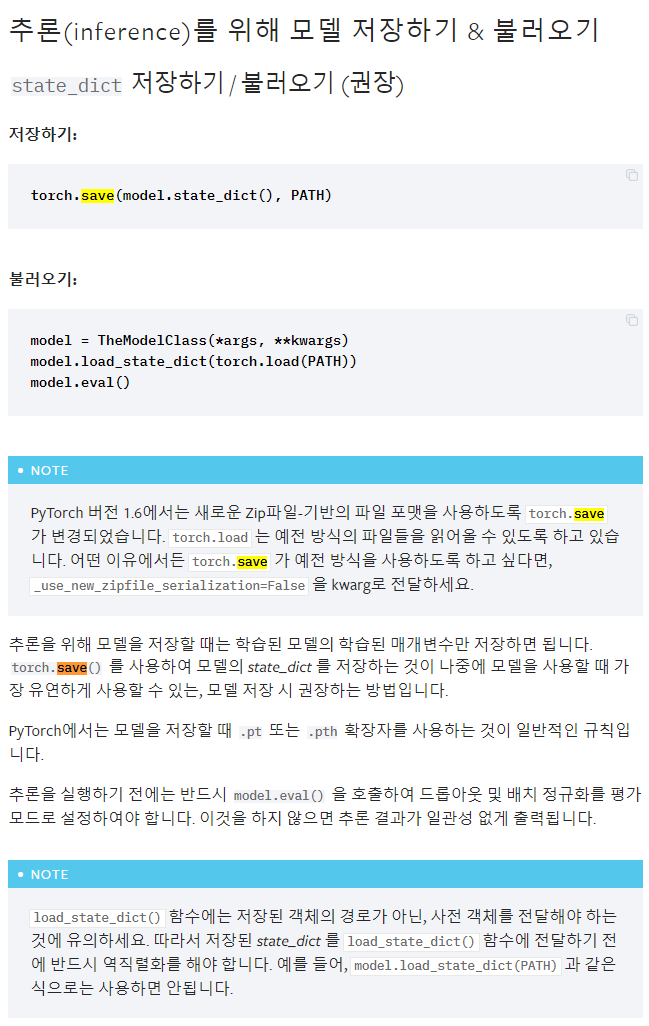